Data from: https://www.kaggle.com/kmader/food41

# Working with Files

In [63]:
import os

In [64]:
os.listdir('Images')

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate']

In [65]:
# Function for moving files - split training and testing data into files
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree

def move_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print(" " + food, end=" ")
#     if food == "chicken_curry":
#         return
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
        try:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
        except:
            return

In [143]:
# Create data txt files with cheesecake, ceasar salad, and chicken curry
def create_food_list(filepath, food_list_filepath, food_list):
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        
    food_list_file = open(food_list_filepath, "w")
    for p in paths:
        food = p.split('/')
        #print(food)
        if food[0] in food_list:
            food_list_file.write(p + "\n")
                #final_food_list.append(p)
    food_list_file.close()

In [144]:
food_list = ['cheesecake', 'baklava', 'carrot_cake']

create_food_list('meta/train.txt', 'meta/train3.txt', food_list)
create_food_list('meta/test.txt', 'meta/test3.txt', food_list)

In [150]:
move_data('meta/train3.txt', 'images', 'train3') # move train images to new file

   baklava      carrot_cake      cheesecake   

In [151]:
move_data('meta/test3.txt', 'images', 'test3')  # move test images to new file

   baklava      carrot_cake      cheesecake   

# Preprocessing Image data

In [152]:
import tensorflow as tf

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [153]:
image_size = (235, 235)
batch_size = 36

train_gen = data_gen.flow_from_directory('train3', target_size=image_size, batch_size=batch_size) # class_mode default categorical
test_gen = data_gen.flow_from_directory('test3', target_size=image_size, batch_size=batch_size)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [154]:
print(train_gen.class_indices)

{'baklava': 0, 'carrot_cake': 1, 'cheesecake': 2}


In [155]:
image_shape = (235, 235, 3)

# Trying different base models

### InceptionV3

In [31]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False) # include top freeze weights

87924736/87910968 [==============================] - 12s 0us/step


In [34]:
inception_model.trainable=False

### VGG16

In [32]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)

58900480/58889256 [==============================] - 8s 0us/step


In [35]:
vgg_model.trainable=False

### MobileNetV2

In [33]:
mobile_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=image_shape, include_top=False)

9420800/9406464 [==============================] - 1s 0us/step


In [36]:
mobile_model.trainable=False

# Creating head of model

### Inception

In [156]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

modelIN = Sequential()
modelIN.add(inception_model)
modelIN.add(Conv2D(32, 3, activation='relu'))  #filters=32, strides=2, kernel_size=(5,5),
modelIN.add(Dropout(0.2))
modelIN.add(GlobalAveragePooling2D()) # avg output of feature map
modelIN.add(Dense(3, activation='softmax'))

modelIN.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 4, 4, 32)          589856    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 22,392,739
Trainable params: 589,955
Non-trainable params: 21,802,784
_________________________________________________________________


In [157]:
modelIN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [158]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

In [159]:
checkpoint = ModelCheckpoint(filepath='model_inception.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

In [160]:
historyIN = modelIN.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - 50s 756ms/step - loss: 1.2169 - accuracy: 0.5489 - val_loss: 0.6842 - val_accuracy: 0.6987

Epoch 00001: val_loss improved from inf to 0.68420, saving model to model_inception.hdf5
Epoch 2/30
63/63 [==============================] - 47s 740ms/step - loss: 0.6240 - accuracy: 0.7324 - val_loss: 0.5971 - val_accuracy: 0.7560

Epoch 00002: val_loss improved from 0.68420 to 0.59711, saving model to model_inception.hdf5
Epoch 3/30
63/63 [==============================] - 47s 752ms/step - loss: 0.4804 - accuracy: 0.8111 - val_loss: 0.4652 - val_accuracy: 0.8120

Epoch 00003: val_loss improved from 0.59711 to 0.46518, saving model to model_inception.hdf5
Epoch 4/30
63/63 [==============================] - 46s 737ms/step - loss: 0.3718 - accuracy: 0.8520 - val_loss: 0.4313 - val_accuracy: 0.8320

Epoch 00004: val_loss improved from 0.46518 to 0.43134, saving model to model_inception.hdf5
Epoch 5/30
63/63 [==============================] - 47s 

<AxesSubplot:>

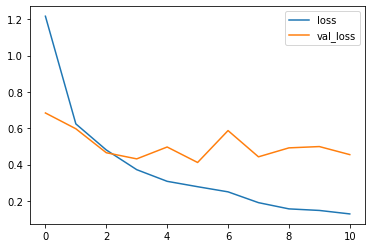

In [161]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()  # learning rate looks good, maybe too high?

<AxesSubplot:>

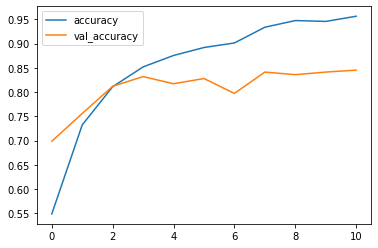

In [174]:
history_df.loc[:,['accuracy', 'val_accuracy']].plot()  # overfitting ish - look at gap

### VGG16

In [175]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

modelVGG = Sequential()
modelVGG.add(vgg_model)
modelVGG.add(Conv2D(32, 3, activation='relu'))  #filters=32, strides=2, kernel_size=(5,5),
modelVGG.add(Dropout(0.2))
modelVGG.add(GlobalAveragePooling2D()) # avg output of feature map
modelVGG.add(Dense(3, activation='softmax'))

modelVGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historyVGG = modelVGG.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - 155s 2s/step - loss: 0.9718 - accuracy: 0.5284 - val_loss: 0.7952 - val_accuracy: 0.6813

Epoch 00001: val_loss did not improve from 0.41143
Epoch 2/30
63/63 [==============================] - 155s 2s/step - loss: 0.7777 - accuracy: 0.6796 - val_loss: 0.7034 - val_accuracy: 0.7120

Epoch 00002: val_loss did not improve from 0.41143
Epoch 3/30
63/63 [==============================] - 159s 3s/step - loss: 0.7099 - accuracy: 0.7071 - val_loss: 0.6760 - val_accuracy: 0.7067

Epoch 00003: val_loss did not improve from 0.41143
Epoch 4/30
63/63 [==============================] - 166s 3s/step - loss: 0.6585 - accuracy: 0.7302 - val_loss: 0.6239 - val_accuracy: 0.7493

Epoch 00004: val_loss did not improve from 0.41143
Epoch 5/30
63/63 [==============================] - 174s 3s/step - loss: 0.6288 - accuracy: 0.7369 - val_loss: 0.6659 - val_accuracy: 0.7000

Epoch 00005: val_loss did not improve from 0.41143
Epoch 6/30
63/63 [=================

KeyboardInterrupt: 

In [ ]:
def plot(history):
    history_df = pd.DataFrame(history.history)
    history_df.loc[:,['loss', 'val_loss']].plot()  
    history_df.loc[:,['accuracy', 'val_accuracy']].plot()

### MobileNetV2

In [176]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

modelMN = Sequential()
modelMN.add(vgg_model)
modelMN.add(Conv2D(32, 3, activation='relu'))  #filters=32, strides=2, kernel_size=(5,5),
modelMN.add(Dropout(0.2))
modelMN.add(GlobalAveragePooling2D()) # avg output of feature map
modelMN.add(Dense(3, activation='softmax'))

earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_inception.h5', verbose=1, save_best_only=True, save_weights_only=True)
modelMN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historyMN = modelMN.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - 162s 3s/step - loss: 0.9427 - accuracy: 0.5622 - val_loss: 0.7333 - val_accuracy: 0.6907

Epoch 00001: val_loss did not improve from 0.41143
Epoch 2/30
63/63 [==============================] - 162s 3s/step - loss: 0.7409 - accuracy: 0.6773 - val_loss: 0.7206 - val_accuracy: 0.6693

Epoch 00002: val_loss did not improve from 0.41143
Epoch 3/30
63/63 [==============================] - 162s 3s/step - loss: 0.6622 - accuracy: 0.7173 - val_loss: 0.6103 - val_accuracy: 0.7360

Epoch 00003: val_loss did not improve from 0.41143
Epoch 4/30
63/63 [==============================] - 166s 3s/step - loss: 0.5981 - accuracy: 0.7591 - val_loss: 0.6035 - val_accuracy: 0.7547

Epoch 00004: val_loss did not improve from 0.41143
Epoch 5/30
63/63 [==============================] - 167s 3s/step - loss: 0.5750 - accuracy: 0.7609 - val_loss: 0.5980 - val_accuracy: 0.7667

Epoch 00005: val_loss did not improve from 0.41143
Epoch 6/30
63/63 [=================

KeyboardInterrupt: 

In [ ]:
modelMN.save("models/modelMN.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_modelMN = converter.convert() #converts our model into a .tflite model which flutter uses 

with open('model.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_modelMN)

In [ ]:
model = keras.models.load_model('path/to/location')


In [172]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

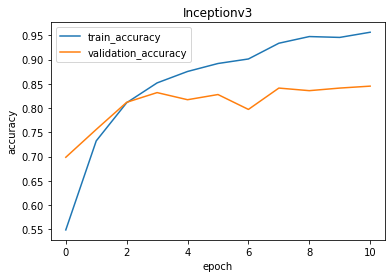

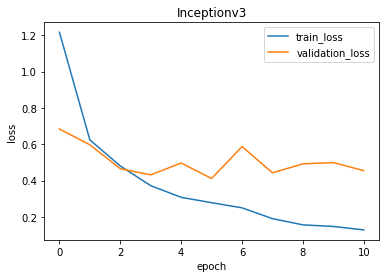

In [173]:
plot_accuracy(history,'Inceptionv3')
plot_loss(history,'Inceptionv3')